In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist

from tensorflow import keras

from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.losses import CategoricalCrossentropy

import numpy as np
import matplotlib.pyplot as plt

# Loading the dataset

In [ ]:
(m_x_train, m_y_train), (m_x_test, m_y_test) = mnist.load_data()


m_x_train = m_x_train / 255
m_x_test = m_x_test / 255


## Splitting the training set into two halves

In [ ]:
m_x_train_04 = m_x_train[m_y_train <= 4] #memorizzo in questa variabile solo la parte di train per gli esempi che hanno etichetta da 0 a 4.
m_y_train_04 = m_y_train[m_y_train <= 4]

m_x_train_59 = m_x_train[m_y_train > 4]
m_y_train_59 = m_y_train[m_y_train > 4]



# modify the y variables to encode them as one-hot vectors
m_y_train_04 = tf.one_hot(m_y_train_04, depth=5)
m_y_train_59 = tf.one_hot(m_y_train_59-5, depth=5)

# Models

## Model for labels 0-4

Let us build a convolutional NN for classifying the digits between 0 and 4. Since we will want to share the weights with the network for classifying the digits between 5 and 9 it helps to structure the network so to group together the layers up to the representation and from the representation to the output.

In Keras we can do that by building a model for the layers up to the representation, one model for the rest of the layer and tiying them together using a third *final* model.

The representation model can be built using the following layers:

- convolution, 32 kernels, kernel size (5,5), strides (2,2), activation relu
- convolution, 64 kernels, kernel size (3,3), activation relu
- maxpool, pool size (2,2)
- dropout 25%
- a "Flatten" layer to create the representation as a single vector

The classification part of the model can be built using the following layers:

- dense, 128 neurons, activation sigmoid
- dropout 25%
- output layer with 5 neurons and softmax activation

The mnist_04 final model is just the concatenation of these two parts


In [ ]:
repr_in_04 = Input(shape=[28,28,1])
x = Conv2D(32, kernel_size=(5,5), strides=(2,2), activation="relu") (repr_in_04)
x = Conv2D(64, kernel_size=(3,3), strides=(2,2), activation="relu") (x)
x = MaxPool2D(pool_size=(2,2)) (x)
x = Dropout(rate=0.25) (x)
repr_out_04 = Flatten() (x)
repr_model_04 = Model(repr_in_04, repr_out_04)


mnist_cls_in_04 = Input(shape=repr_out_04.shape[1:])
x = Dense(128, activation="sigmoid") (mnist_cls_in_04)
x = Dropout(0.25)(x)
mnist_cls_out_04 = Dense(5, activation="softmax") (x)

mnist_cls_04 = Model(mnist_cls_in_04, mnist_cls_out_04)

mnist_04 = Model(repr_in_04, mnist_cls_04(repr_model_04(repr_in_04)))


## Model for labels 5-9

The model for classifying digits between 5 and 9 is just a replica of the model for classifying digits between 0 and 4.

In [ ]:

repr_in_59 = Input(shape=[28,28,1])
x = Conv2D(32, kernel_size=(5,5), strides=(2,2), activation="relu") (repr_in_59)
x = Conv2D(64, kernel_size=(3,3), strides=(2,2), activation="relu") (x)
x = MaxPool2D(pool_size=(2,2)) (x)
x = Dropout(rate=0.25) (x)
repr_out_59 = Flatten() (x)

repr_model_59 = Model(repr_in_59, repr_out_59)



mnist_cls_in_59 =  Input(shape=repr_out_04.shape[1:])

x = Dense(128, activation="sigmoid") (mnist_cls_in_59)
x = Dropout(0.25)(x)
mnist_cls_out_59 = Dense(5, activation="softmax") (x)

mnist_cls_59 = Model(mnist_cls_in_59, mnist_cls_out_59)

mnist_59 =  Model(repr_in_59, mnist_cls_59( repr_model_59(repr_in_59) )  )

## Fitting the 0-4 model

In [ ]:
mnist_04.compile(loss="categorical_crossentropy", metrics="accuracy")

In [ ]:
tf_callback_04 = tf.keras.callbacks.TensorBoard(log_dir="logs/04")
hist_04 = mnist_04.fit(m_x_train_04, m_y_train_04, epochs=5, callbacks=[tf_callback_04]) #callbacks è una lista di funzioni che invoca ad intervalli regolari (alla fine di ogni epoca di default)

Epoch 1/5
  1/957 [..............................] - ETA: 0s - loss: 1.9144 - accuracy: 0.1562WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
957/957 [==============================] - 9s 9ms/step - loss: 0.1916 - accuracy: 0.9388
Epoch 2/5
957/957 [==============================] - 8s 9ms/step - loss: 0.0783 - accuracy: 0.9756
Epoch 3/5
957/957 [==============================] - 8s 9ms/step - loss: 0.0623 - accuracy: 0.9807
Epoch 4/5
957/957 [==============================] - 12s 12ms/step - loss: 0.0571 - accuracy: 0.9825
Epoch 5/5
957/957 [==============================] - 8s 9ms/step - loss: 0.0498 - accuracy: 0.9850


## Sharing the representation layer weights

If we check the weights of the two model's representation layers, we see thay are not shared (we could have shared by building the models from the same definitions of the layers).

In [ ]:

diffs = np.array(mnist_04.layers[1].get_weights()) - np.array(mnist_59.layers[1].get_weights())
for i in range(diffs.shape[0]):
    print(np.sum(np.abs(diffs[i])))

85.11949
1.7032628
1587.5774
3.6385446


Let us set the mnist_59 weights for the representation layer be equal to those of the mnist_04 model.

In [ ]:
mnist_59.layers[1].set_weights(mnist_04.layers[1].get_weights()) #setto i pesi del nuovo modello uguali a quelli del modello
#già addestrato e che magari per essere addestrato ha avuto bisogno di molto tempo.

In [ ]:
diffs = np.array(mnist_04.layers[1].get_weights()) - np.array(mnist_59.layers[1].get_weights())
for i in range(diffs.shape[0]):
    print(np.sum(np.abs(diffs[i])))

0.0
0.0
0.0
0.0


## Fitting the 59 model

Before training the mnist_59 model we want to make the representation layer not trainable.

In [ ]:
mnist_59.layers[1].trainable = False #dico che la parte di rappresentazione (livelli convoluzionali ecc..)
#del nuovo modello non è più addestrabile
mnist_59.compile(loss="categorical_crossentropy", metrics="accuracy")

tf_callback_59 = tf.keras.callbacks.TensorBoard(log_dir="logs/59")
# shall we use Tensorboard?
hist_59 = mnist_59.fit(m_x_train_59, m_y_train_59, epochs=5, callbacks=[tf_callback_59])

Epoch 1/5
919/919 [==============================] - 3s 4ms/step - loss: 0.3333 - accuracy: 0.8922
Epoch 2/5
919/919 [==============================] - 4s 4ms/step - loss: 0.2129 - accuracy: 0.9261
Epoch 3/5
919/919 [==============================] - 4s 4ms/step - loss: 0.1963 - accuracy: 0.9336
Epoch 4/5
919/919 [==============================] - 3s 4ms/step - loss: 0.1857 - accuracy: 0.9385
Epoch 5/5
919/919 [==============================] - 4s 4ms/step - loss: 0.1760 - accuracy: 0.9409


# MNIST no representation learning

To compare results from the transfer learning settings with something sensible, let us then build a model that contains only the classification part (in this way we can apreciate what the representation learning part buys us).

In [ ]:
norepr_cls_in_59 = Input(shape=[28,28,1])
x = Flatten() (norepr_cls_in_59)
x = Dense(128, activation="sigmoid") (x)
x = Dropout(0.25)(x)
norepr_cls_out_59 = Dense(5, activation="softmax") (x)

norepr_model_59 = Model(norepr_cls_in_59, norepr_cls_out_59)

In [ ]:
norepr_model_59.compile(loss="categorical_crossentropy", metrics="accuracy")
tf_callback_59_norepr = tf.keras.callbacks.TensorBoard(log_dir="logs/591")
# shall we use Tensorboard?
norepr_hist = norepr_model_59.fit(m_x_train_59, m_y_train_59, epochs=5, callbacks=[tf_callback_59_norepr])

Epoch 1/5
919/919 [==============================] - 2s 3ms/step - loss: 0.2980 - accuracy: 0.9079
Epoch 2/5
919/919 [==============================] - 2s 2ms/step - loss: 0.1584 - accuracy: 0.9497
Epoch 3/5
919/919 [==============================] - 2s 2ms/step - loss: 0.1244 - accuracy: 0.9609
Epoch 4/5
919/919 [==============================] - 2s 2ms/step - loss: 0.1069 - accuracy: 0.9676
Epoch 5/5
919/919 [==============================] - 2s 2ms/step - loss: 0.0935 - accuracy: 0.9706


# Plotting results

The fit function returns an object with a `history` attribute containing the recording of training metrics through the epochs. We can use that information to plot what happened during training.

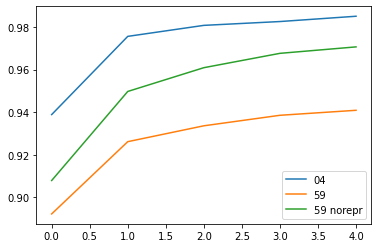

In [ ]:
plt.plot(hist_04.history['accuracy'], label="04")
plt.plot(hist_59.history['accuracy'], label="59")
plt.plot(norepr_hist.history['accuracy'], label="59 norepr")
plt.legend()